# Mask R-CNN - Inspect Custom Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import car

%matplotlib inline 

# Directory to save logs and trained model
#MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = "/home/dw/logs/car20190618T1245"

#custom_WEIGHTS_PATH = "mask_rcnn_damage_0010.h5"  # TODO: update this path
CAR_WEIGHTS_PATH = "/home/dw/logs/car20190618T1245/mask_rcnn_car_0015.h5" # TODO: update this path

Using TensorFlow backend.


## Configurations

In [2]:
config = car.CarConfig()
#car_DIR = os.path.join(ROOT_DIR, "customImages")
car_DIR = "/home/dw/Deep-Learning/car_detection/car"

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                22
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

## Notebook Preferences

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [4]:
# Load validation dataset
dataset = car.CarDataset()
dataset.load_car(car_DIR, "test")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 9
Classes: ['BG', 'headLamp', 'radiatorGrill', 'characterLine', 'waistLine', 'sideSkirt', 'rearLamp', 'muffler', 'wheel', 'sideMirror']


## Load Model

In [5]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
    
# load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", CAR_WEIGHTS_PATH)
model.load_weights(CAR_WEIGHTS_PATH, by_name=True)

from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights  /home/dw/logs/car20190618T1245/mask_rcnn_car_0015.h5
Re-starting from epoch 15


<module 'mrcnn.visualize' from '/home/dw/Deep-Learning/car_detection/mrcnn/visualize.py'>

# Run Detection on Images

8
image ID: car.images-6006.jpeg (8) /home/dw/Deep-Learning/car_detection/car/test/images-6006.jpeg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min:    6.00000  max:    6.00000  int32
gt_bbox                  shape: (2, 4)                min:  125.00000  max:  879.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


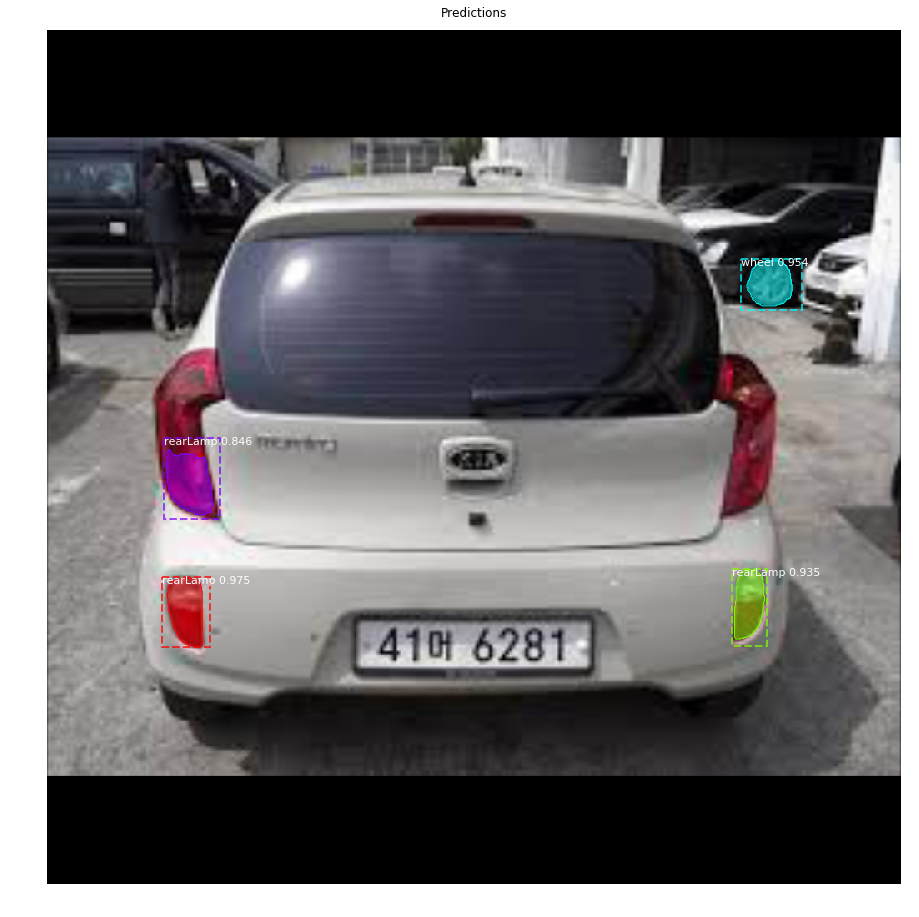

In [6]:
image_id = random.choice(dataset.image_ids)
print(image_id)

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Step By Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1. RPN Targets

### 2. RPN Predictions

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 1. Proposal Classification

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 10)         min:    0.00000  max:    0.99997  float32
deltas                   shape: (1, 1000, 10, 4)      min:   -4.68417  max:    4.14233  float32
masks                    shape: (1, 100, 28, 28, 10)  min:    0.00001  max:    0.99887  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    8.00000  float32
4 detections: ['rearLamp' 'wheel' 'rearLamp' 'rearLamp']


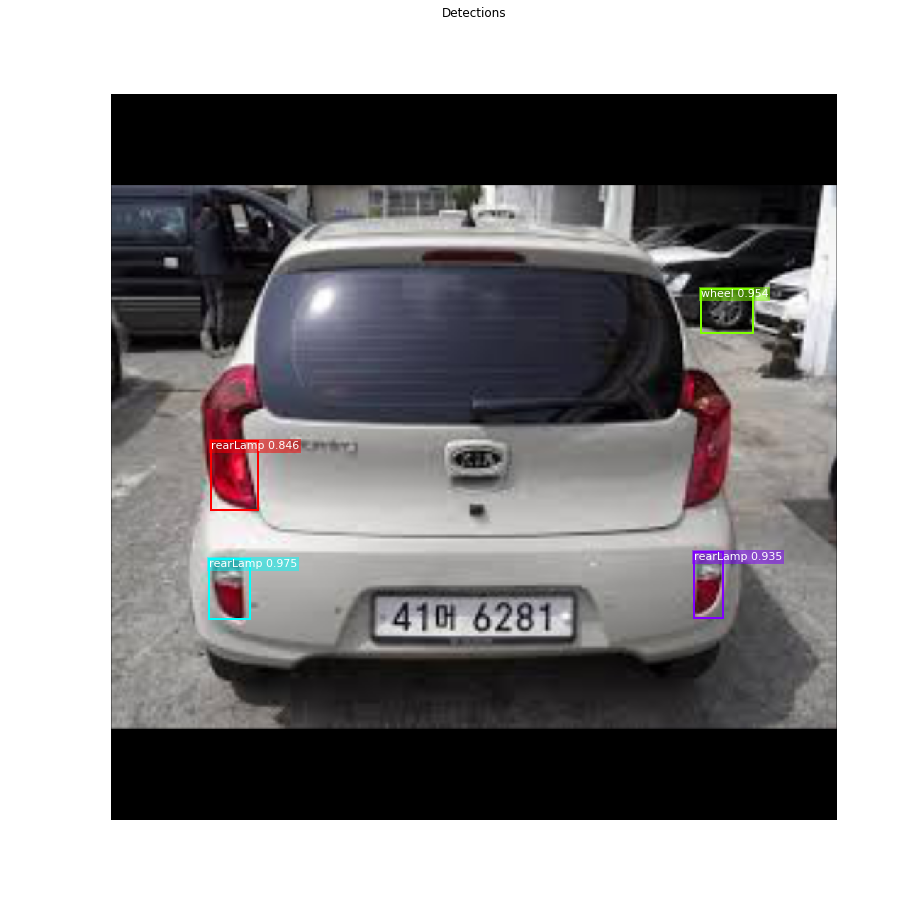

In [7]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

# Precision-Recall

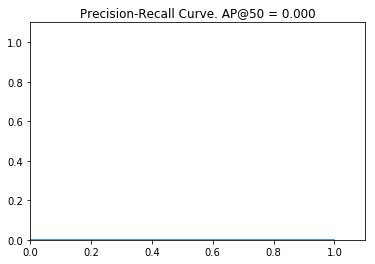

In [8]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

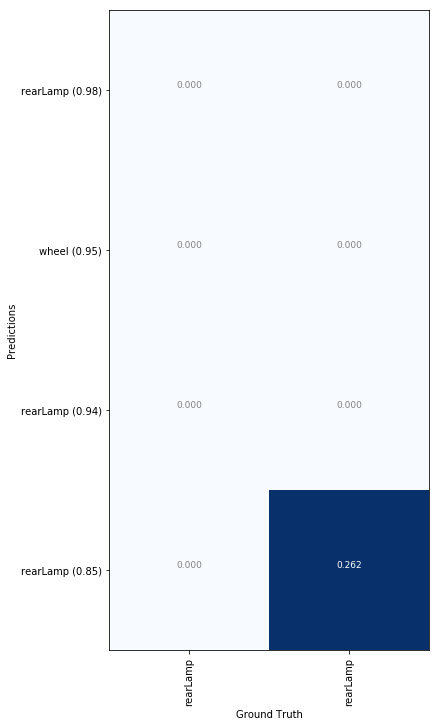

In [9]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

# Evaluation